In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
print("imports ok")

imports ok


In [ ]:
"""
Python classification
There are 3 types of input features:
    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.
Features:
    Age | Objective Feature | age | int (days)
    
    Height | Objective Feature | height | int (cm) |
    
    Weight | Objective Feature | weight | float (kg) |
    
    Gender | Objective Feature | gender | categorical code | 1: femme 2: homme |
    
    Systolic blood pressure | Examination Feature | ap_hi | int |
    
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal|
    
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    
    Smoking | Subjective Feature | smoke | binary |
    
    Alcohol intake | Subjective Feature | alco | binary |
    
    Physical activity | Subjective Feature | active | binary |
    
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
    """

In [ ]:
"""
Il s'agit de faire de la classification ici.
on veut faire un modèle capable de prédire si la personne aura des pbs cardio-vasculaires

"""

In [3]:
#lecture du CSV de données avec pandas :
csv = pd.read_csv(r"./data/cardio_train.csv", error_bad_lines=False, delimiter=";")
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# la colonne des ages est trop funky, ajout d'une colonne en années pour visualisation :
csv["age_years"] = csv.age.map(lambda x: round(x/365.25, 2))

In [182]:
# IMC ou BMI est une mesure utilisée pour mesurée l'état physique des gens 
# La fonction est déclarée ici pour clarté, 
# mais elle aurait très bien marché en lambda pour aller plus vite
def calcimc(line):
    return int(round(line["weight"]/ ((line["height"]/100)**2),2)*10)

In [183]:
#BMI*10 attention
csv["BMI"] = csv.apply(calcimc, axis=1) #axis=1 applique la fonction à chaque ligne
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,b_gender
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,219,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,349,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,235,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,287,0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,230,1


In [7]:
csv.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.302869,27.555311
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.754974,6.092596
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.560000,3.500000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.360000,23.900000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.940000,26.400000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.390000,30.200000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.920000,298.700000


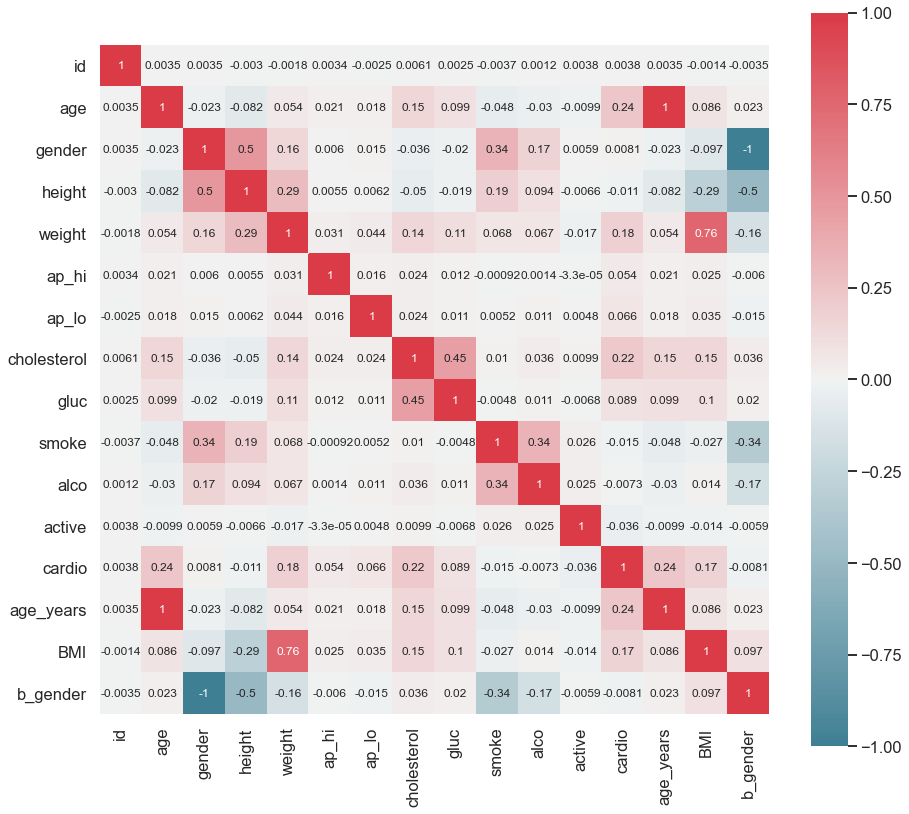

In [184]:
# représentation des corrélations entre les variables en heatmap :

corr = csv.corr()
_ , ax = plt.subplots(figsize =( 15 , 15 ))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

In [ ]:
# corrélation étrange entre la taille et le genre ?

In [16]:
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0


In [20]:
# on ré-écrit la colonne gender avec des 0 et des 1 :
# il semble manquer les infos sur à quoi correspondent les catégories dans le sujet !
csv["b_gender"] = csv.gender.map(lambda x: 1 if x==1 else 0)
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,b_gender
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7,0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0,1


In [32]:
# il faut séparer la variable cholestérol en 3 colonnes binaires :
chol_dummy = pd.get_dummies( csv.cholesterol , prefix='Chol')
print(chol_dummy.head())

# idem pour le glucose :
gluc_dummy = pd.get_dummies( csv.gluc , prefix='gluc')
print("\n",gluc_dummy.head())

   Chol_1  Chol_2  Chol_3
0       1       0       0
1       0       0       1
2       0       0       1
3       1       0       0
4       1       0       0

    gluc_1  gluc_2  gluc_3
0       1       0       0
1       1       0       0
2       1       0       0
3       1       0       0
4       1       0       0


In [26]:
# on vérifie si des données sont manquantes 
csv.isna().any()
# tout semble ok

id             False
age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
age_years      False
BMI            False
b_gender       False
dtype: bool

In [206]:
# assemblage d'une dataframe avec toute les variables pour le training :

# suppression des col inutiles sur la df du csv :
csv_pruned = csv.drop(['id', 'gender','cholesterol', 'gluc',
                       'height', 'weight', 'age_years', 'cardio'], axis=1)


full_df = pd.concat( [ csv_pruned , chol_dummy] , axis=1 )
full_df.head()

# csv.BMI
reduced_df = csv[['ap_hi', 'ap_lo', 'BMI']]
reduced_df.head()

,ap_hi,ap_lo,BMI
0,110,80,219
1,140,90,349
2,130,70,235
3,150,100,287
4,100,60,230


In [210]:
# split du dataset en deux groupes : train et validation :
train_X , valid_X , train_y , valid_y = train_test_split( full_df , csv.cardio ,
                                                         train_size = .7 )

tr_x , vl_x , tr_y , vl_y = train_test_split( reduced_df , csv.cardio ,
                                                         train_size = .7 )

#voir si il faut du test en plus ici
test_X = valid_X.sample(frac = 0.5)
test_Y = valid_y[test_X.index]
valid_X.drop(test_X.index, inplace=True)
valid_y.drop(test_X.index, inplace=True) #this is ok

print (full_df.shape , train_X.shape , valid_X.shape ,
       train_y.shape , valid_y.shape , test_X.shape)

(70000, 11) (49000, 11) (10500, 11) (49000,) (10500,) (10500, 11)


0.9993877551020408


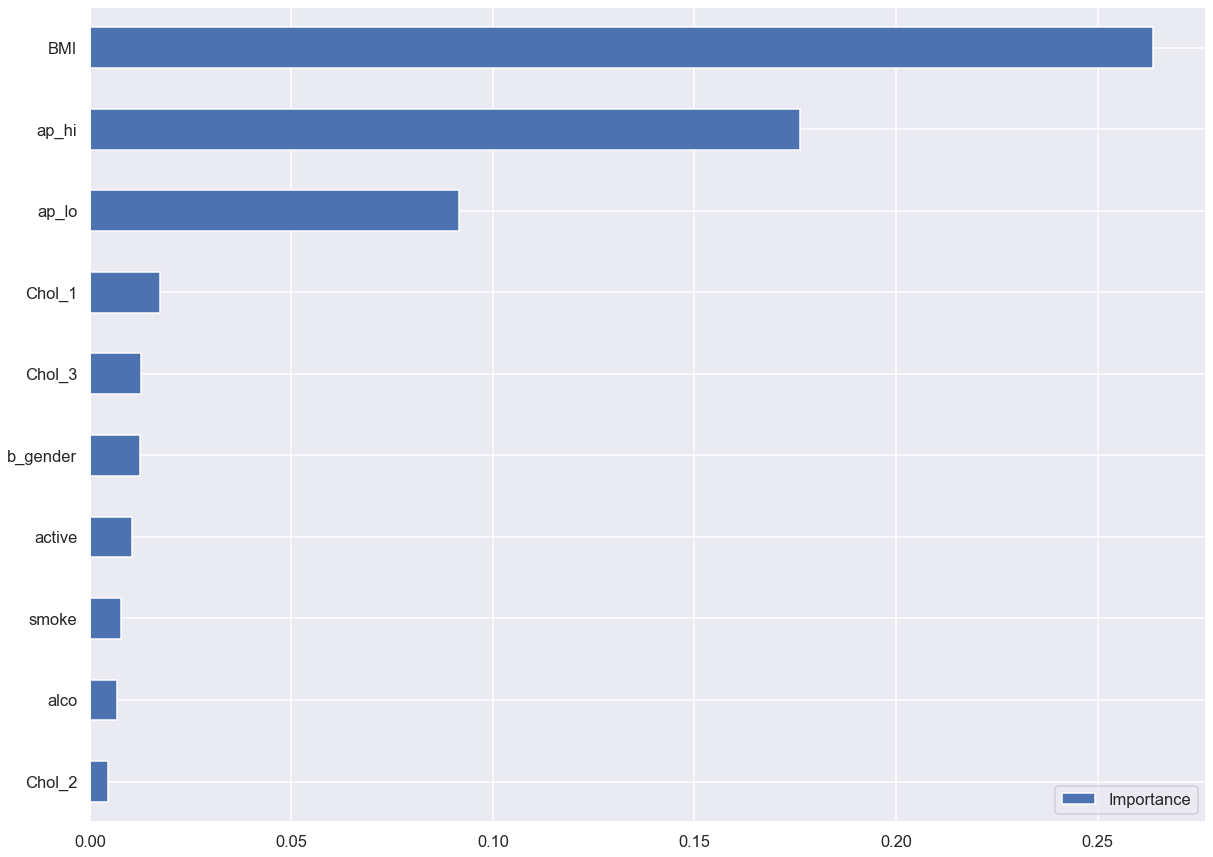

In [191]:
def plot_variable_importance( X , y ):
    classif = RandomForestClassifier( random_state = 99 )
    classif.fit( X , y )
    plot_model_var_imp( classif , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
plot_variable_importance(train_X, train_y)

In [193]:
# Models models models and models
rand_for = RandomForestClassifier(n_estimators=1000,
                                  max_depth = 7,      #advice says btwn 5-15 to reduce overfitting
                                  min_samples_leaf=5,
                                  max_features=0.5,
                                  n_jobs=-1
                                 )
sup_vec_mach = SVC()
grad_boost = GradientBoostingClassifier()
k_nearest= KNeighborsClassifier(n_neighbors = 3)
gau_naive= GaussianNB()
logi_reg= LogisticRegression()

In [194]:
rand_for.fit( train_X , train_y )
sup_vec_mach.fit( train_X , train_y )
grad_boost.fit( train_X , train_y )
k_nearest.fit( train_X , train_y )
gau_naive.fit( train_X , train_y )
logi_reg.fit( train_X , train_y )

LogisticRegression()

In [195]:
# exécution un peu lente pour tous les modèles ensemble mais c'est ok :)
print (sup_vec_mach.score( train_X , train_y ) , sup_vec_mach.score( valid_X , valid_y ))
print (rand_for.score( train_X , train_y ) , rand_for.score( valid_X , valid_y ))
print (grad_boost.score( train_X , train_y ) , grad_boost.score( valid_X , valid_y ))
print (k_nearest.score( train_X , train_y ) , k_nearest.score( valid_X , valid_y ))
print (gau_naive.score( train_X , train_y ) , gau_naive.score( valid_X , valid_y ))
print (logi_reg.score( train_X , train_y ) , logi_reg.score( valid_X , valid_y ))

data = [['sup_vec_mach_train', sup_vec_mach.score( train_X , train_y ), 'train', 'Support Vector Machines'] , 
        ['sup_vec_mach_eval',sup_vec_mach.score( valid_X , valid_y ), 'eval', 'Support Vector Machines'],
        ['rand_for_train', rand_for.score( train_X , train_y ), 'train', 'Random forest'] ,
        ['rand_for_eval',rand_for.score( valid_X , valid_y ), 'eval', 'Random forest'],
        ['grad_boost_train',grad_boost.score( train_X , train_y ), 'train', 'Gradient Boosting Classifier'], 
        ['grad_boost_eval',grad_boost.score( valid_X , valid_y), 'eval', 'Gradient Boosting Classifier'],
        ['k_nearest_train', k_nearest.score( train_X , train_y ), 'train', 'K-nearest neighbors'] , 
        ['k_nearest_eval',k_nearest.score( valid_X , valid_y ), 'eval', 'K-nearest neighbors'],
        ['gau_naive_train', gau_naive.score( train_X , train_y ), 'train', 'Gaussian Naive Bayes'] ,
        ['gau_naive_eval', gau_naive.score( valid_X , valid_y ), 'eval', 'Gaussian Naive Bayes'],
        ['logi_reg_train', logi_reg.score( train_X , train_y ), 'train', 'Logistic Regression'],
        ['logi_reg_eval',logi_reg.score( valid_X , valid_y ), 'eval', 'Logistic Regression']]

df = pd.DataFrame(data, columns = ['Name', 'Score', 'Dataset type', 'Model type']) 
df.head()

0.6118163265306122 0.6140952380952381
0.7412040816326531 0.7351428571428571
0.7403061224489796 0.7331428571428571
0.8151836734693878 0.659047619047619
0.5975918367346938 0.604
0.6520612244897959 0.6618095238095238


,Name,Score,Dataset type,Model type
0,sup_vec_mach_train,0.611816,train,Support Vector Machines
1,sup_vec_mach_eval,0.614095,eval,Support Vector Machines
2,rand_for_train,0.741204,train,Random forest
3,rand_for_eval,0.735143,eval,Random forest
4,grad_boost_train,0.740306,train,Gradient Boosting Classifier


Text(0.5, 1.0, 'Prediction accuracy by model & dataset type (more is better)')

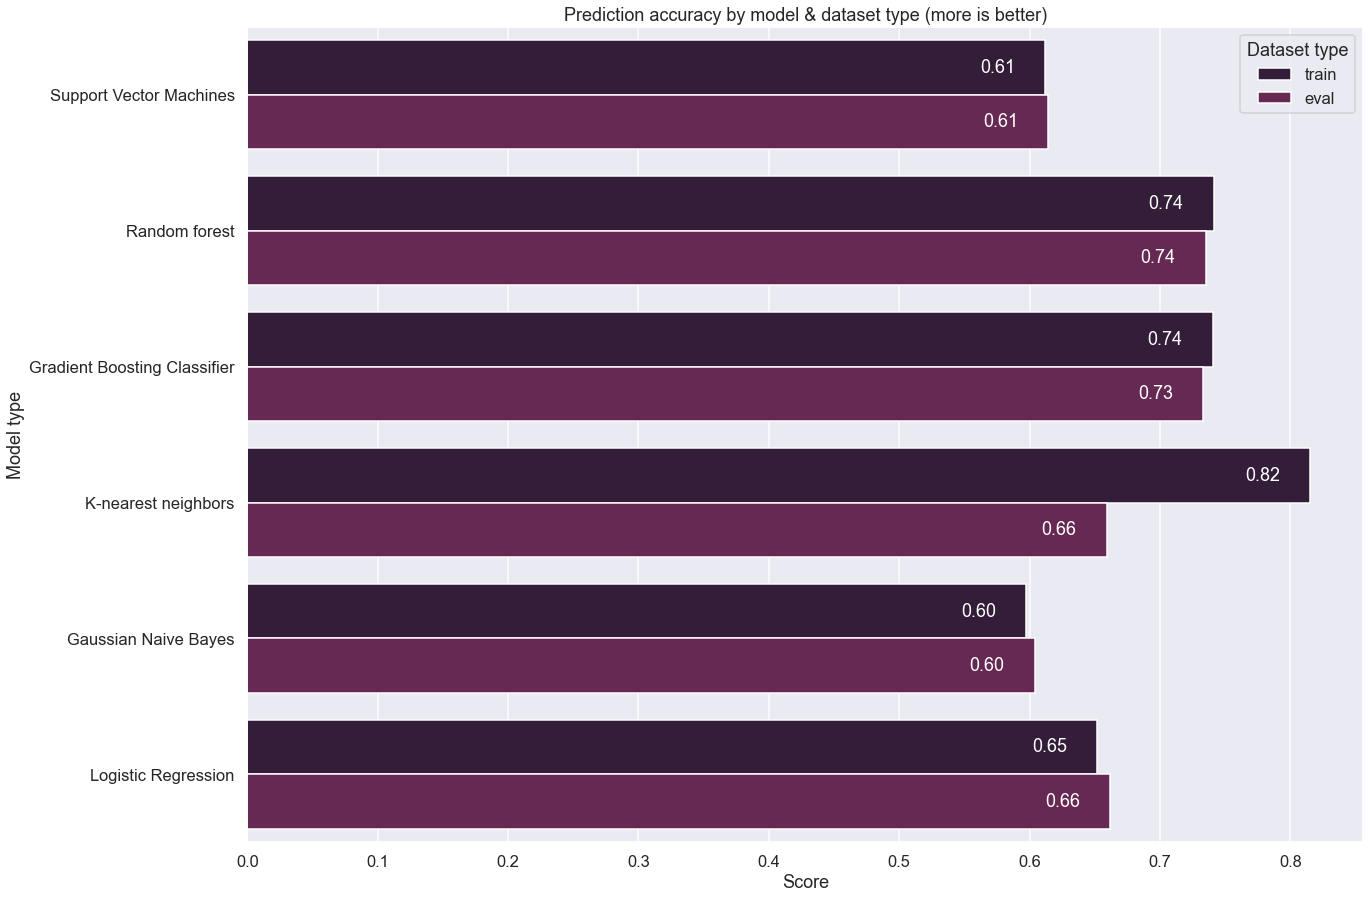

In [196]:
#pretty barplot visualisation
sns.set_context("talk")
# sns.set(rc={'figure.figsize':(20,15)})
pal =sns.color_palette("rocket")
bar = sns.barplot(data = df
            ,x = 'Score'
            ,y = 'Model type'
            ,hue = 'Dataset type'
            ,ci = None
            ,orient = 'h'
            ,palette = pal
            )
# # for legend text 
# plt.setp(bar.get_legend().get_texts(), fontsize='20') 

# plt.setp(bar.get_legend().get_title(), fontsize='30')   


# bar.
for p in bar.patches:
    width = p.get_width()    # get bar length
    bar.text(width-0.05,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center',# vertical alignment
            color = 'white')  

bar.set_title("Prediction accuracy by model & dataset type (more is better)")

0.9993877551020408


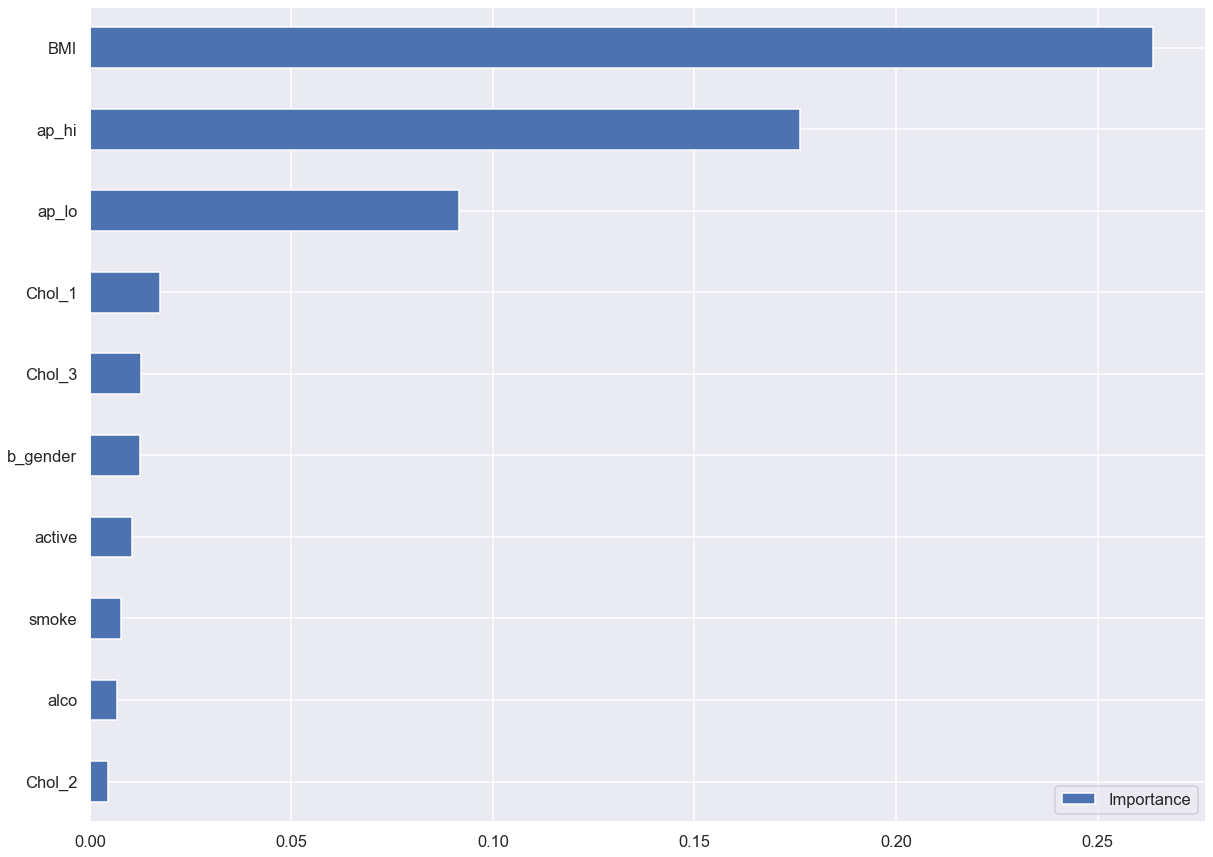

In [197]:
plot_variable_importance(train_X, train_y)

In [212]:
#on va pimper le random forest sa mère
rand_for = RandomForestClassifier(n_estimators=1000,
                                  max_depth = 7,      #advice says btwn 5-15 to reduce overfitting
                                  min_samples_leaf=5,
                                  max_features=0.5,
                                  n_jobs=-1
                                 )

rand_for.fit( train_X , train_y )

print(f"""
Training accuracy: {round(rand_for.score( train_X , train_y ),4)}     
Validation accuracy: {round(rand_for.score( valid_X , valid_y ),4)}    
Test accuracy: {round(rand_for.score( test_X , test_Y ),4)} """)


Training accuracy: 0.741     
Validation accuracy: 0.7301    
Test accuracy: 0.7318 


Text(0.5, 1.0, 'Prediction accuracy in relation to min_samples_leaf by dataset type (more is better)')

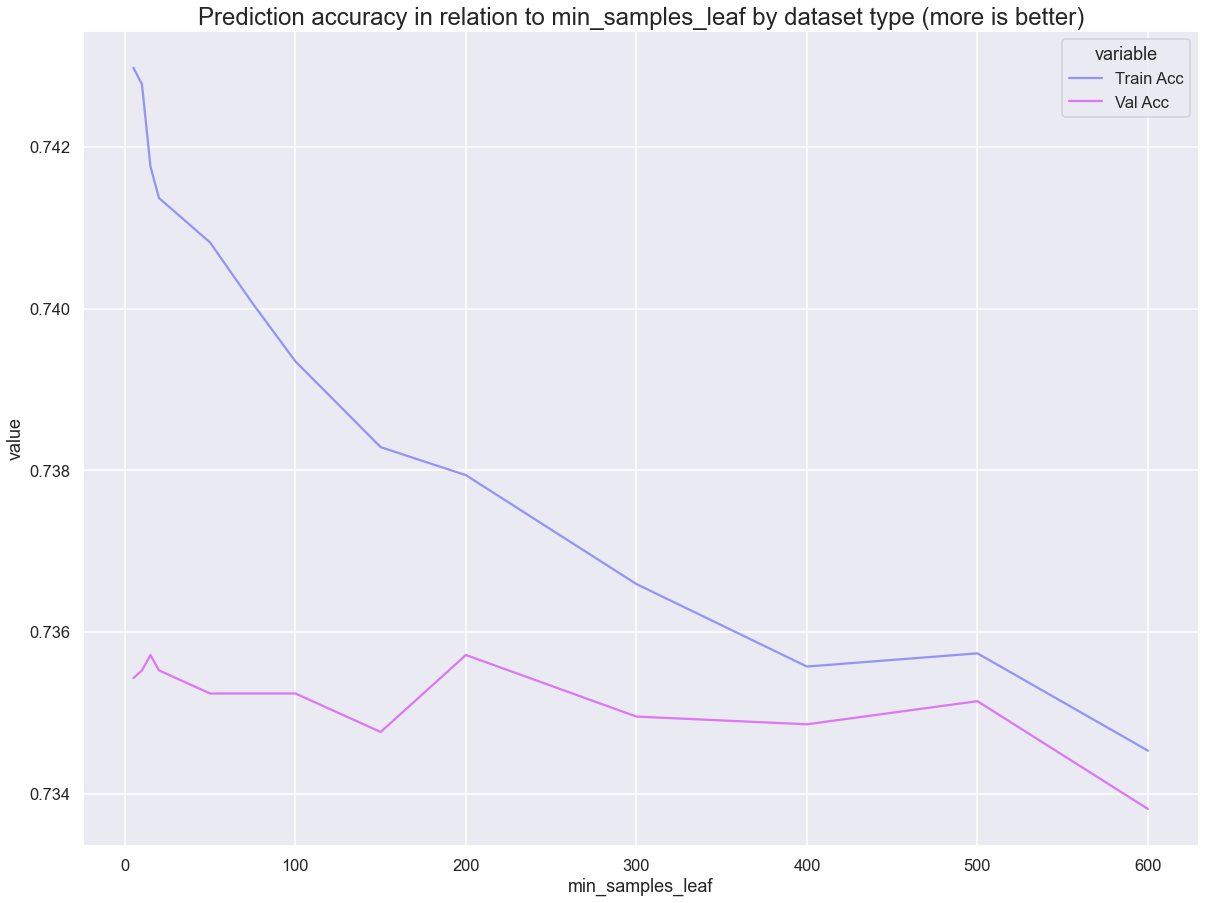

In [159]:
# APE TOGETHER WITH LOOP STRONK
val = [5, 10, 15, 20, 50, 75, 100, 150, 200, 300, 400, 500, 600]
res_l = []
for elem in val :
    rand_for = RandomForestClassifier(n_estimators=500,
                                      max_depth = 7,      
                                      min_samples_leaf=elem,
                                      max_features=0.5,
                                      n_jobs=-1)
    
    rand_for.fit( train_X , train_y )
    
    res_l.append((elem,rand_for.score( train_X , train_y ), rand_for.score( valid_X , valid_y )))
    
res_df = pd.DataFrame(res_l, columns=["min_samples_leaf", "Train Acc", "Val Acc"])

################################## PLOTTING ##################################
# ("#9593FA", "#DC77F6", "#FF65C8")
pal = ["#9593FA", "#DC77F6"]

line = sns.lineplot(x='min_samples_leaf', 
             y='value', 
             hue='variable', 
             data=pd.melt(res_df, ['min_samples_leaf']),
             palette=pal)
line.set_title(
    "Prediction accuracy in relation to min_samples_leaf by dataset type (more is better)", size=24)


Text(0.5, 1.0, 'Prediction accuracy in relation to max_features & dataset type (more is better)')

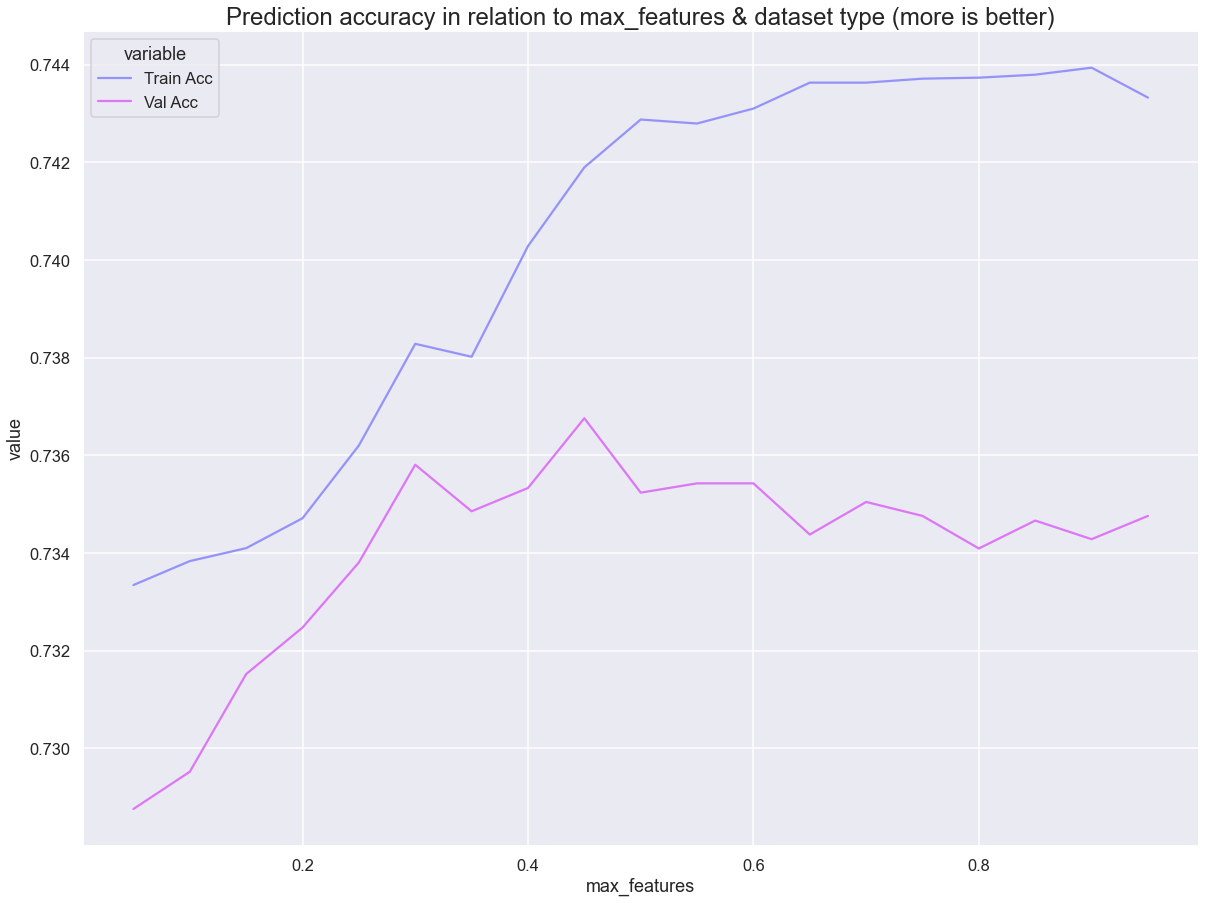

In [160]:
# APE SMORT 
# floating point junkyard magic adapted from stackoverflow:
import decimal
def drange(x, y, jump):
    x = decimal.Decimal(x)
    while x < y:
        yield decimal.Decimal(x)
        x += decimal.Decimal(jump)

res_l = []
for elem in drange('0.05', 1.0, '0.05') :
    rand_for = RandomForestClassifier(n_estimators=500,
                                      max_depth = 7,      
                                      min_samples_leaf=5,
                                      max_features=elem,
                                      n_jobs=-1)
    
    rand_for.fit( train_X , train_y )
    
    res_l.append((elem,rand_for.score( train_X , train_y ), rand_for.score( valid_X , valid_y )))

res_df_feat = pd.DataFrame(res_l, columns=["max_features", "Train Acc", "Val Acc"])
# res_df_feat
################################## PLOTTING ##################################
pal = ["#9593FA", "#DC77F6"]
line = sns.lineplot(x='max_features', 
             y='value', 
             hue='variable', 
             data=pd.melt(res_df_feat, ['max_features']),
             palette=pal
            )

line.set_title(
    "Prediction accuracy in relation to max_features & dataset type (more is better)", size=24)

Text(0.5, 1.0, 'Prediction accuracy in relation to max_features & dataset type (more is better)')

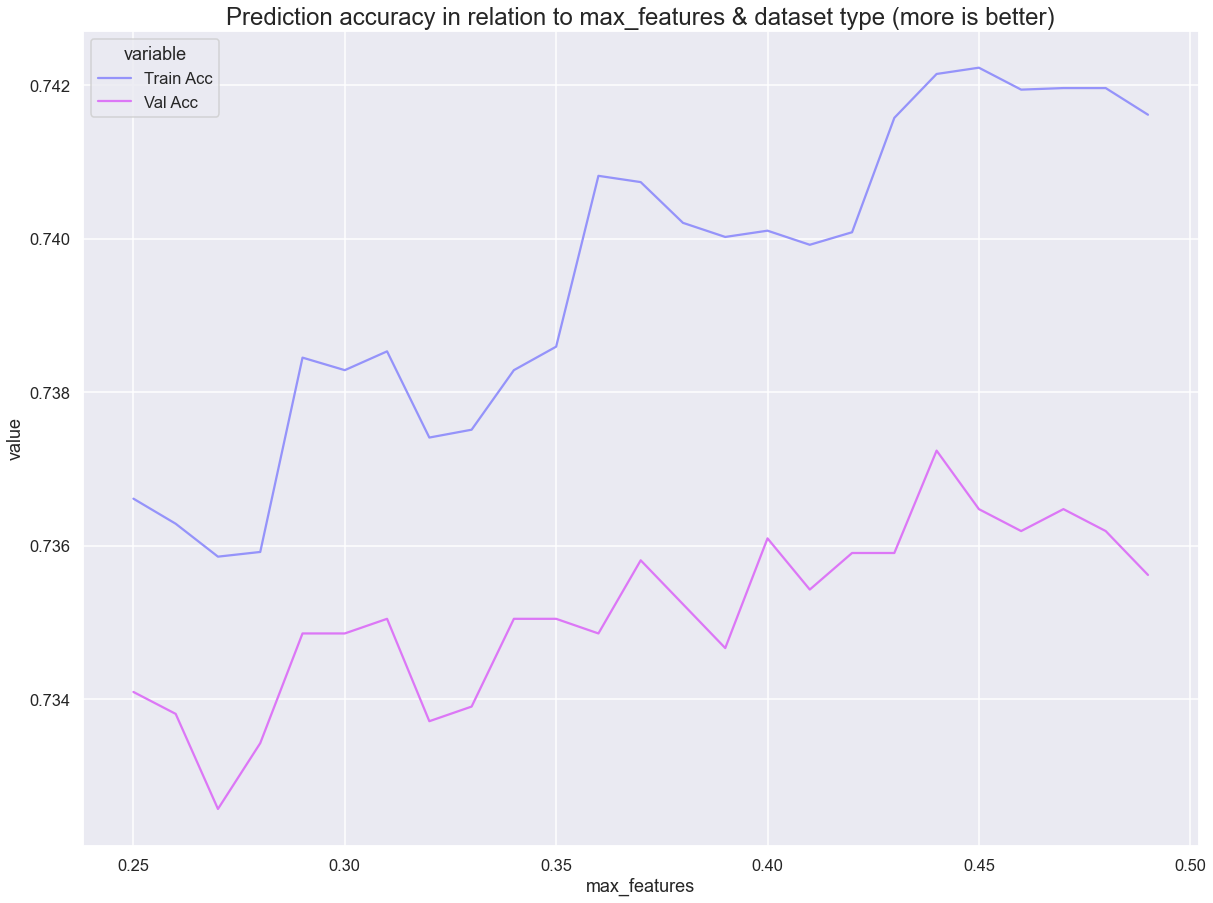

In [163]:
# ENHENCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEE
# floating point junkyard magic adapted from stackoverflow:
import decimal
def drange(x, y, jump):
    x = decimal.Decimal(x)
    while x < y:
        yield decimal.Decimal(x)
        x += decimal.Decimal(jump)

res_l = []
for elem in drange('0.25', 0.5, '0.01') :
    rand_for = RandomForestClassifier(n_estimators=500,
                                      max_depth = 7,      
                                      min_samples_leaf=5,
                                      max_features=elem,
                                      n_jobs=-1)
    
    rand_for.fit( train_X , train_y )
    
    res_l.append((elem,rand_for.score( train_X , train_y ), rand_for.score( valid_X , valid_y )))

res_df_feat = pd.DataFrame(res_l, columns=["max_features", "Train Acc", "Val Acc"])
# res_df_feat
################################## PLOTTING ##################################
pal = ["#9593FA", "#DC77F6"]
line = sns.lineplot(x='max_features', 
             y='value', 
             hue='variable', 
             data=pd.melt(res_df_feat, ['max_features']),
             palette=pal
            )

line.set_title(
    "Prediction accuracy in relation to max_features & dataset type (more is better)", size=24)

In [172]:
rf_df = pd.concat( [ csv_pruned , chol_dummy] , axis=1 )

rf_train_X , rf_valid_X , rf_train_y , rf_valid_y = train_test_split( rf_df , csv.cardio ,
                                                         train_size = .8 )

############################################################
rf_test_X = rf_valid_X.sample(frac = 0.5)
rf_test_Y = rf_valid_y[rf_test_X.index]

rf_valid_X.drop(rf_test_X.index, inplace=True)
rf_valid_y.drop(rf_test_Y.index, inplace=True) #this is ok

##########################################################
rand_for = RandomForestClassifier(n_estimators=1500,
                                  max_depth = 7,      #advice says btwn 5-15 to reduce overfitting
                                  min_samples_leaf=5,
                                  max_features=0.44,
                                  n_jobs=-1
                                 )


rand_for.fit( rf_train_X , rf_train_y )

print(f"""
Random Forrest :
Training accuracy: {round(rand_for.score( rf_train_X , rf_train_y ),4)}     
Validation accuracy: {round(rand_for.score( rf_valid_X , rf_valid_y ),4)}    
Test accuracy: {round(rand_for.score( rf_test_X , rf_test_Y ),4)} """)


Random Forrest :
Training accuracy: 0.7391     
Validation accuracy: 0.7314    
Test accuracy: 0.7326 


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

grid_clf.cv_results_